In [131]:
import pyxdf
import mne
from mne.decoding import CSP
from mne.preprocessing import EOGRegression
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split

from mnetools import streams2mnedata, preprocessing

In [132]:
# -- |Data details| --
participant_id = 4
session = 2
# -- |Data Selection| --
initial_run = 1
n_run = 5

# -- |Parameters| --
tmin= -0.5
tmax= 3

# -- |Event dictionary| --
# Set up your event name
if session == 1 : events_id = {'right': 0, 'left': 1}
else            : events_id = {'none': 0, 'right': 1, 'left': 2}

# **Raw Data Overview**

In [133]:
# -- |Local parameters|--
epochs_list = [] 

for i in range(initial_run,initial_run+n_run):
    # -- |File import| --
    streams, header = pyxdf.load_xdf(f"Data/sub-P{participant_id:003d}/ses-S{session:003d}/eeg/sub-P{participant_id:003d}_ses-S{session:003d}_task-Default_run-{i:003d}_eeg.xdf") #Example Data from Lab Recoder

    raw_mne, events = streams2mnedata(streams)
    epochs = mne.Epochs(raw_mne, events, tmin= -0.5,  tmax= 3, event_id = events_id, preload = True,verbose=False,picks = ['C3','Cz','C4','PO7','Pz','PO8','EOG'])

    epochs_list.append(epochs)

epochs = mne.concatenate_epochs(epochs_list)
epochs.set_montage(mne.channels.make_standard_montage('standard_1020'))

Number of events,230
Events,left: 75none: 80right: 75
Time range,-0.500 – 3.000 s
Baseline,-0.500 – 0.000 s


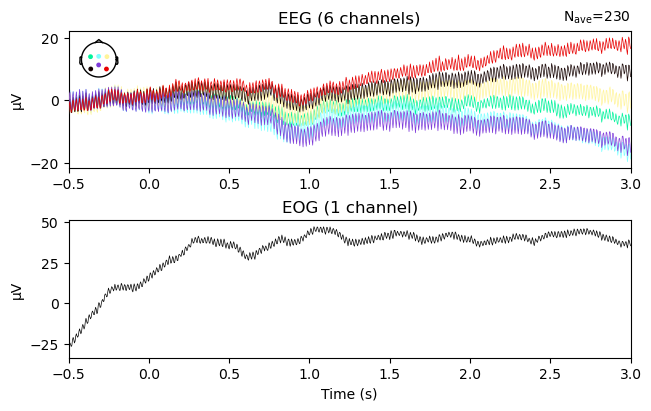

In [134]:
plot_kwargs = dict(picks="all")

# plot the evoked for the EEG and the EOG sensors
fig = epochs.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


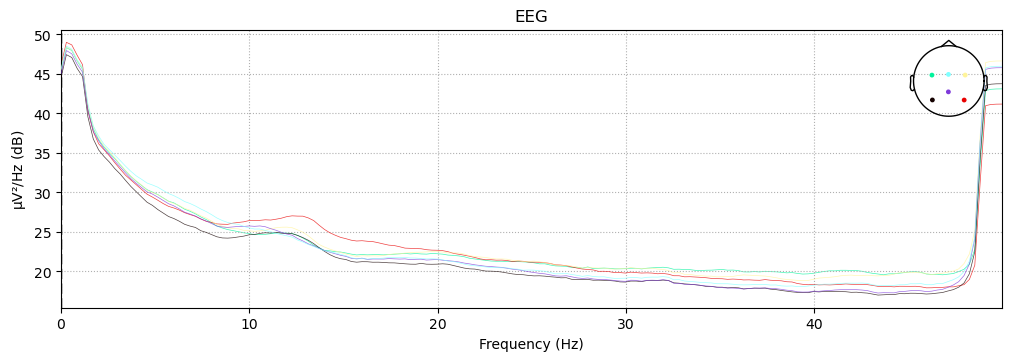

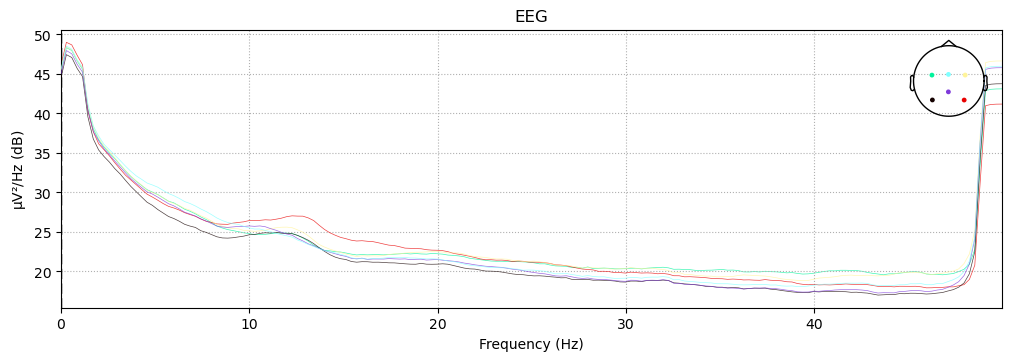

In [135]:
epochs.compute_psd(fmin=0,fmax=50).plot()

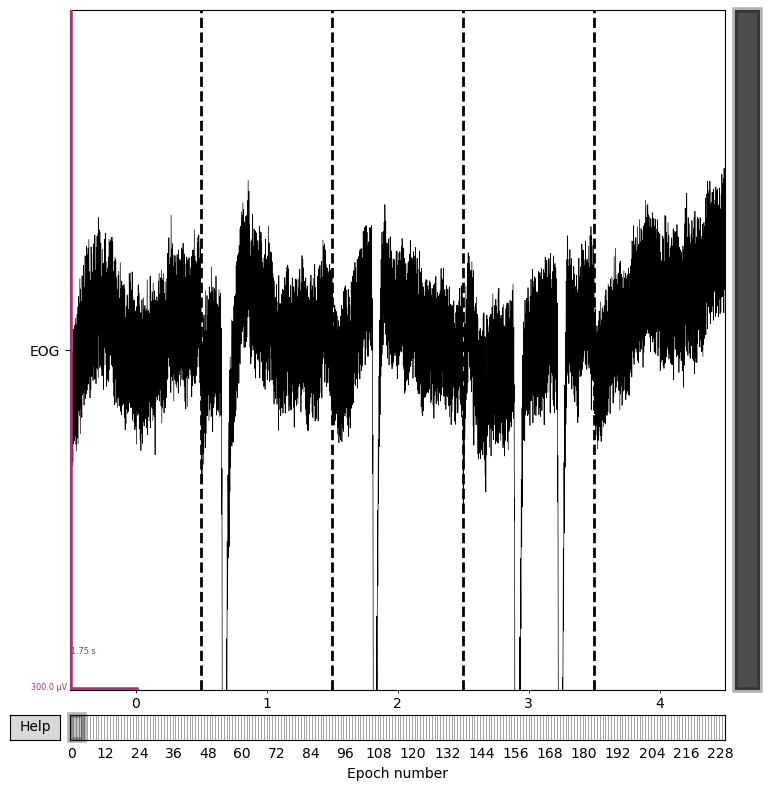

In [136]:
epochs.plot(picks='EOG', n_epochs=5);

# **Processing**

In [137]:
# -- |Local parameters|--
epochs_list = [] 

for i in range(initial_run,initial_run+n_run):
    # -- |File import| --
    streams, header = pyxdf.load_xdf(f"Data/sub-P{participant_id:003d}/ses-S{session:003d}/eeg/sub-P{participant_id:003d}_ses-S{session:003d}_task-Default_run-{i:003d}_eeg.xdf") #Example Data from Lab Recoder

    raw_mne, events = streams2mnedata(streams)
    prepro_mne = preprocessing(raw_mne)
    
    # -- |Epoch Segmentation| --
    epochs = mne.Epochs(prepro_mne, events, tmin= tmin,  tmax= tmax, event_id = events_id, preload = True,verbose=False,picks = ['C3','Cz','C4','PO7','Pz','PO8','EOG'])

    epochs_list.append(epochs)

epochs = mne.concatenate_epochs(epochs_list)
epochs.set_montage(mne.channels.make_standard_montage('standard_1020'))

Number of events,230
Events,left: 75none: 80right: 75
Time range,-0.500 – 3.000 s
Baseline,-0.500 – 0.000 s


## Part 1: Without artifact removal

### 1.1 Left vs. Right Classification

#### 1.1.1 SVM

Train set shape: (120, 7, 876)
Test set shape : (30, 7, 876)
Using all features ----------------------------------------------


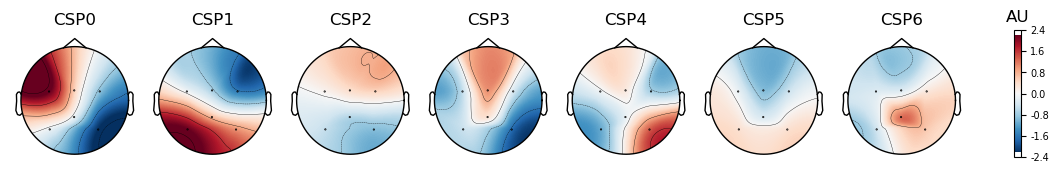

Train Accuracy: 0.6583333333333333
Test  Accuracy: 0.5666666666666667
              precision    recall  f1-score   support

       right       0.57      0.53      0.55        15
        left       0.56      0.60      0.58        15

    accuracy                           0.57        30
   macro avg       0.57      0.57      0.57        30
weighted avg       0.57      0.57      0.57        30

Using features which yield maximum accuracy----------------------
Train set shape: (120, 7, 876)
Test set shape : (30, 7, 876)


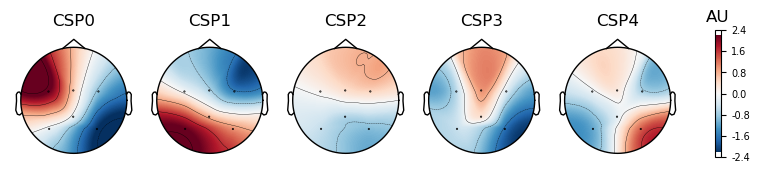

Train Accuracy: 0.5833333333333334
Test  Accuracy: 0.6
              precision    recall  f1-score   support

       right       0.62      0.53      0.57        15
        left       0.59      0.67      0.62        15

    accuracy                           0.60        30
   macro avg       0.60      0.60      0.60        30
weighted avg       0.60      0.60      0.60        30



In [139]:
mne.set_log_level(verbose=False)

# Get EEG data and events
X = epochs[['right','left']].get_data(copy=False)
Y = epochs[['right','left']].events[:, -1]

csp_list = []
svm_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Fit CSP to data 
    csp.fit(X_train,Y_train)
    csp_list.append(csp)

    # Transform data into CSP space
    X_train_transformed = csp.transform(X_train)
    X_test_transformed = csp.transform(X_test)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train_transformed, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test_transformed)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, svm.predict(X_train_transformed)))

    report = classification_report(Y_test, y_pred, target_names=['right', 'left'])  # adjust target names accordingly
    report_list.append(report)

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 1.1.2 Logistic Regression

Using all features ----------------------------------------------
Train set shape: (120, 4)
Test set shape : (30, 4)


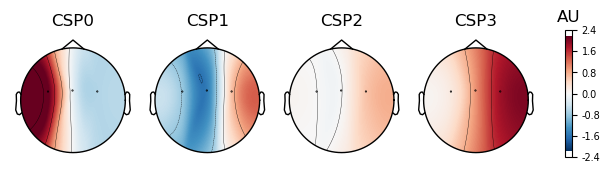

Train Accuracy: 0.6666666666666666
Test  Accuracy: 0.5333333333333333
              precision    recall  f1-score   support

  none-right       0.53      0.60      0.56        15
       right       0.54      0.47      0.50        15

    accuracy                           0.53        30
   macro avg       0.53      0.53      0.53        30
weighted avg       0.53      0.53      0.53        30

Using features which yield maximum accuracy----------------------
Train set shape: (120, 4)
Test set shape : (30, 4)


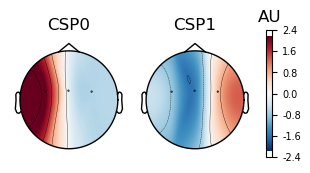

Train Accuracy: 0.6333333333333333
Test  Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

  none-right       0.67      0.67      0.67        15
       right       0.67      0.67      0.67        15

    accuracy                           0.67        30
   macro avg       0.67      0.67      0.67        30
weighted avg       0.67      0.67      0.67        30



In [ ]:
csp_list = []
lr_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, lr.predict(X_train)))

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

### 1.2 Left vs. Non-left Classification

#### 1.2.1 SVM

c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\li

Using all features ----------------------------------------------
Train set shape: (184, 4)
Test set shape : (46, 4)


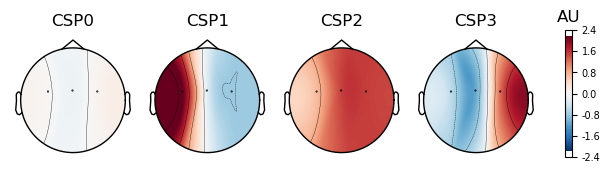

Train Accuracy: 0.6739130434782609
Test  Accuracy: 0.6739130434782609
              precision    recall  f1-score   support

       right       0.67      1.00      0.81        31
        left       0.00      0.00      0.00        15

    accuracy                           0.67        46
   macro avg       0.34      0.50      0.40        46
weighted avg       0.45      0.67      0.54        46

Using features which yield maximum accuracy----------------------
Train set shape: (184, 4)
Test set shape : (46, 4)


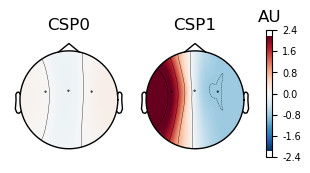

Train Accuracy: 0.6739130434782609
Test  Accuracy: 0.6739130434782609
              precision    recall  f1-score   support

       right       0.67      1.00      0.81        31
        left       0.00      0.00      0.00        15

    accuracy                           0.67        46
   macro avg       0.34      0.50      0.40        46
weighted avg       0.45      0.67      0.54        46



In [ ]:
epochs_l = epochs.copy()
epochs_l.events = mne.merge_events(epochs_l.events, [0, 1], 0, replace_events=True)
epochs_l.event_id = {'none-left': 0, 'left': 2}

# Get EEG data and events
X = epochs_l.get_data(copy=False)
Y = epochs_l.events[:, -1]

csp_list = []
svm_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, svm.predict(X_train)))

    report = classification_report(Y_test, y_pred, target_names=['right', 'left'])  # adjust target names accordingly
    report_list.append(report)

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 1.2.2 Logistic Regression

Using all features ----------------------------------------------
Train set shape: (184, 4)
Test set shape : (46, 4)


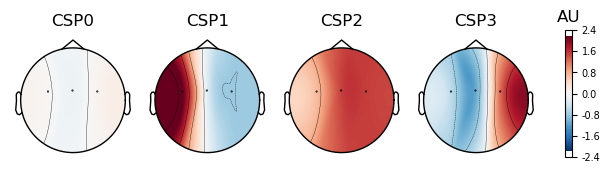

Train Accuracy: 0.6684782608695652
Test  Accuracy: 0.6739130434782609
              precision    recall  f1-score   support

  none-right       0.70      0.90      0.79        31
       right       0.50      0.20      0.29        15

    accuracy                           0.67        46
   macro avg       0.60      0.55      0.54        46
weighted avg       0.63      0.67      0.62        46

Using features which yield maximum accuracy----------------------
Train set shape: (184, 4)
Test set shape : (46, 4)


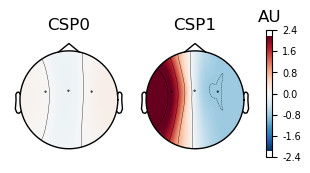

Train Accuracy: 0.6902173913043478
Test  Accuracy: 0.6739130434782609
              precision    recall  f1-score   support

  none-right       0.69      0.94      0.79        31
       right       0.50      0.13      0.21        15

    accuracy                           0.67        46
   macro avg       0.60      0.53      0.50        46
weighted avg       0.63      0.67      0.60        46



In [ ]:
csp_list = []
lr_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, lr.predict(X_train)))

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

### 1.3 Right vs. Non-Right Classification

#### 1.3.1 SVM

Using all features ----------------------------------------------
Train set shape: (184, 4)
Test set shape : (46, 4)


c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\li

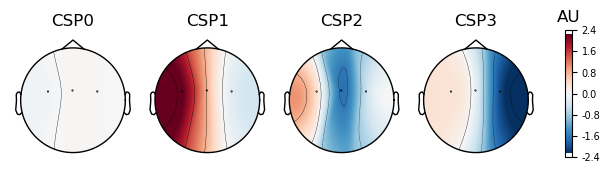

Train Accuracy: 0.6739130434782609
Test  Accuracy: 0.6739130434782609
              precision    recall  f1-score   support

       right       0.67      1.00      0.81        31
        left       0.00      0.00      0.00        15

    accuracy                           0.67        46
   macro avg       0.34      0.50      0.40        46
weighted avg       0.45      0.67      0.54        46

Using features which yield maximum accuracy----------------------
Train set shape: (184, 4)
Test set shape : (46, 4)


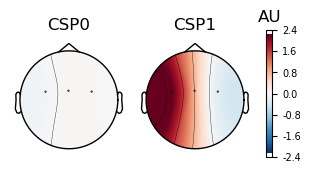

Train Accuracy: 0.6739130434782609
Test  Accuracy: 0.6739130434782609
              precision    recall  f1-score   support

       right       0.67      1.00      0.81        31
        left       0.00      0.00      0.00        15

    accuracy                           0.67        46
   macro avg       0.34      0.50      0.40        46
weighted avg       0.45      0.67      0.54        46



In [ ]:
epochs_r = epochs.copy()
epochs_r.events = mne.merge_events(epochs_r.events, [0, 2], 0, replace_events=True)
epochs_r.event_id = {'none-right': 0, 'right': 1}

# Get EEG data and events
X = epochs_r.get_data(copy=False)
Y = epochs_r.events[:, -1]

csp_list = []
svm_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, svm.predict(X_train)))

    report = classification_report(Y_test, y_pred, target_names=['right', 'left'])  # adjust target names accordingly
    report_list.append(report)

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 1.3.2 Logistic Regression

Using all features ----------------------------------------------
Train set shape: (184, 4)
Test set shape : (46, 4)


c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


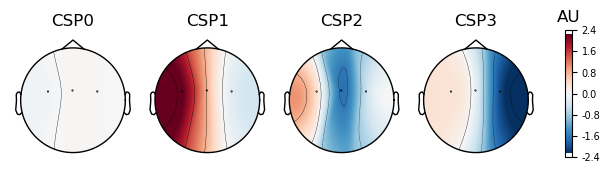

Train Accuracy: 0.6956521739130435
Test  Accuracy: 0.6086956521739131
              precision    recall  f1-score   support

  none-right       0.65      0.90      0.76        31
       right       0.00      0.00      0.00        15

    accuracy                           0.61        46
   macro avg       0.33      0.45      0.38        46
weighted avg       0.44      0.61      0.51        46

Using features which yield maximum accuracy----------------------
Train set shape: (184, 4)
Test set shape : (46, 4)


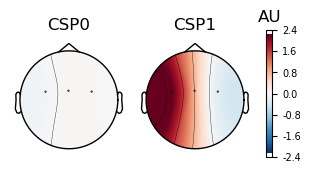

Train Accuracy: 0.6739130434782609
Test  Accuracy: 0.6739130434782609
              precision    recall  f1-score   support

  none-right       0.67      1.00      0.81        31
       right       0.00      0.00      0.00        15

    accuracy                           0.67        46
   macro avg       0.34      0.50      0.40        46
weighted avg       0.45      0.67      0.54        46



In [ ]:
csp_list = []
lr_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, lr.predict(X_train)))

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

## Part 2: With artifact removal

### Artifact Correlations

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_59480\2921723998.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_59480\2921723998.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


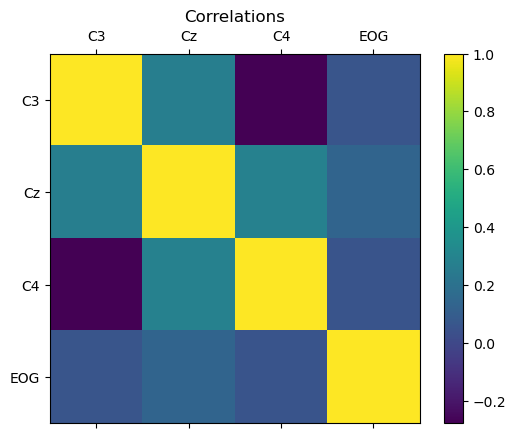

,C3,Cz,C4,EOG
C3,1.000000,0.267869,-0.276525,0.058085
Cz,0.267869,1.000000,0.284490,0.135015
C4,-0.276525,0.284490,1.000000,0.056350
EOG,0.058085,0.135015,0.056350,1.000000


In [ ]:
df = epochs.to_data_frame()
df_numerical = df[epochs.ch_names]

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df_numerical.corr(), interpolation='nearest')
fig.colorbar(cax)

alpha = epochs.ch_names
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
ax.set_title('Correlations')

plt.show()
df_numerical.corr()

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_59480\3594465532.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_59480\3594465532.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


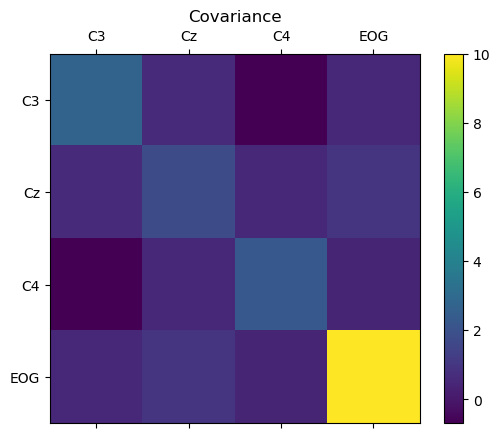

,C3,Cz,C4,EOG
C3,2.722405,0.584226,-0.683762,0.484916
Cz,0.584226,1.747289,0.563565,0.903009
C4,-0.683762,0.563565,2.245895,0.427281
EOG,0.484916,0.903009,0.427281,25.600951


In [ ]:
df = epochs.to_data_frame()
df_numerical = df[epochs.ch_names]

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df_numerical.cov(), interpolation='nearest',vmax=10)
fig.colorbar(cax)

alpha = epochs.ch_names
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
ax.set_title('Covariance')

plt.show()
df_numerical.cov()

In [ ]:
df_numerical.corr()['EOG'][:-1].mul(df_numerical.std().iloc[:-1]/df_numerical.std().iloc[-1])

C3    0.018941
Cz    0.035272
C4    0.016690
dtype: float64

### 2.1 Visualize Original Data

#### Signal Average Over Epochs

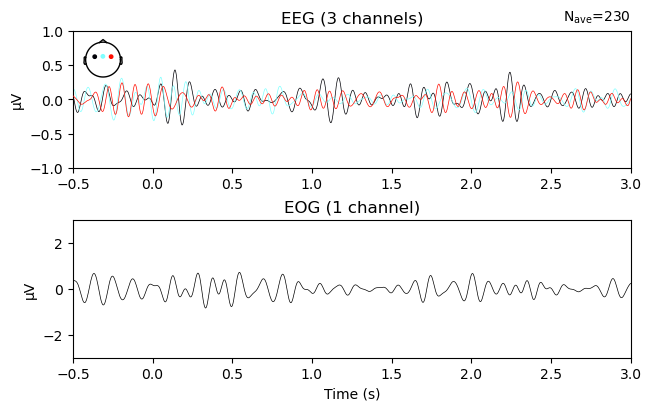

In [ ]:
plot_kwargs = dict(picks="all", ylim=dict(eeg=(-1, 1), eog=(-3, 3)))

# plot the evoked for the EEG and the EOG sensors
fig = epochs.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

#### Time Domain Plot

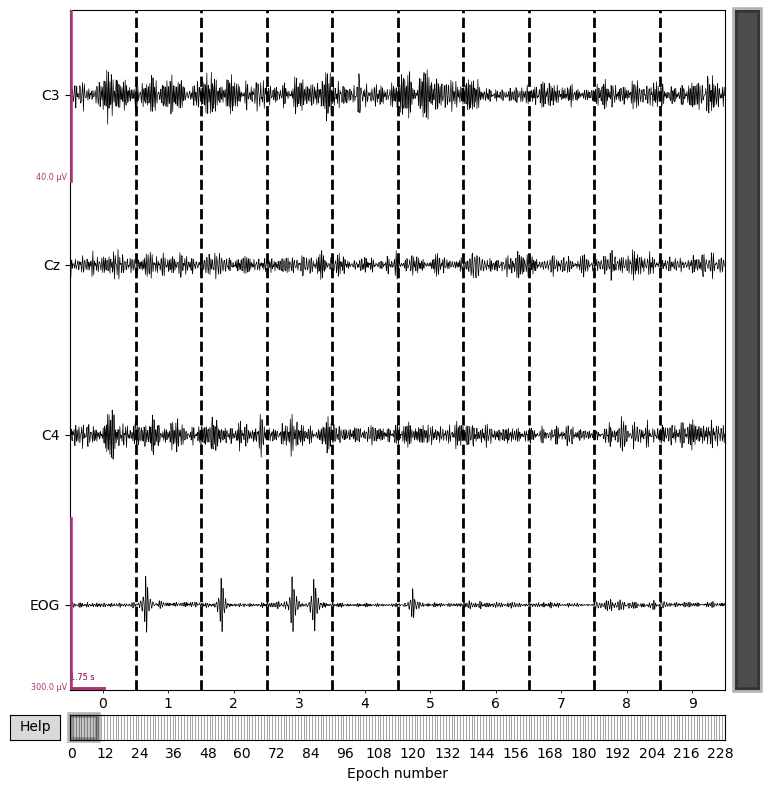

In [ ]:
epochs.plot(picks='all', n_epochs=10);

### 2.2 Compute and Apply EOG Regression

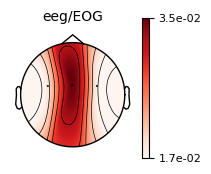

In [ ]:
# Perform regression using the EOG sensor as independent variable and the EEG
# sensors as dependent variables.
model_plain = EOGRegression(picks="eeg", picks_artifact="eog").fit(epochs)

epochs_clean_plain = model_plain.apply(epochs)
# After regression, we should redo the baseline correction
epochs_clean_plain.apply_baseline()

fig = model_plain.plot()  # regression coefficients as topomap
fig.set_size_inches(3, 2)

In [ ]:
model_plain.coef_

array([[0.01889894],
       [0.03519927],
       [0.016652  ]])

#### Signal Average Over Epochs

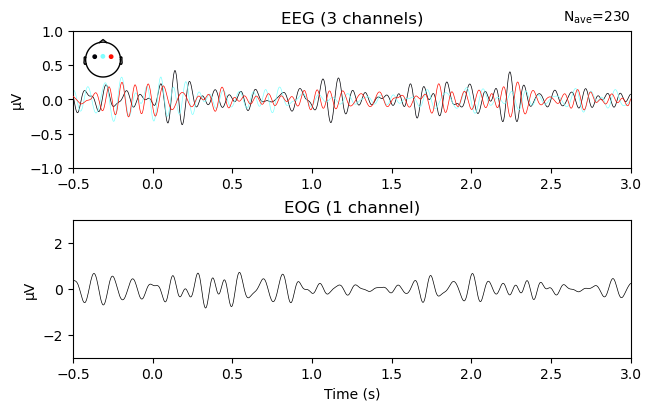

In [ ]:
# Show the evoked potential computed on the corrected data
fig = epochs_clean_plain.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

#### Time Domain Plot

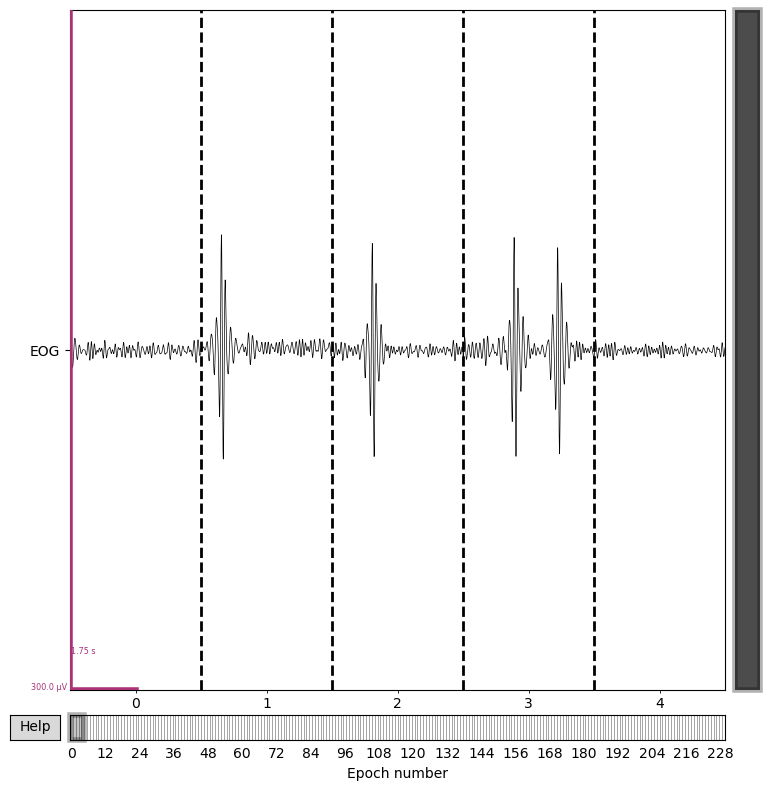

In [ ]:
epochs_clean_plain.plot(picks='EOG', n_epochs=5);

### 2.3 Left vs. Right Classification

#### 2.3.1 SVM

Using all features ----------------------------------------------
Train set shape: (120, 4)
Test set shape : (30, 4)


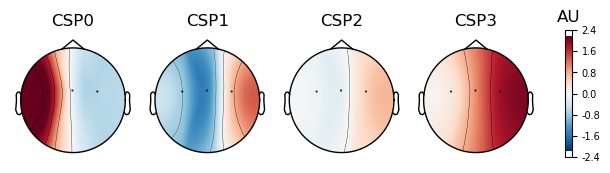

Train Accuracy: 0.625
Test  Accuracy: 0.6
              precision    recall  f1-score   support

       right       0.62      0.53      0.57        15
        left       0.59      0.67      0.62        15

    accuracy                           0.60        30
   macro avg       0.60      0.60      0.60        30
weighted avg       0.60      0.60      0.60        30

Using features which yield maximum accuracy----------------------
Train set shape: (120, 4)
Test set shape : (30, 4)


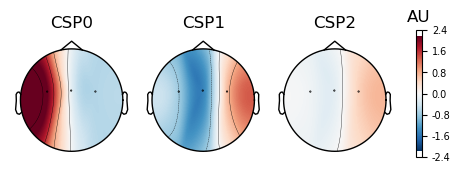

Train Accuracy: 0.6166666666666667
Test  Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

       right       0.69      0.60      0.64        15
        left       0.65      0.73      0.69        15

    accuracy                           0.67        30
   macro avg       0.67      0.67      0.67        30
weighted avg       0.67      0.67      0.67        30



In [ ]:
# Get EEG data and events
X = epochs_clean_plain[['right','left']].get_data(copy=False)
Y = epochs_clean_plain[['right','left']].events[:, -1]

csp_list = []
svm_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, svm.predict(X_train)))

    report = classification_report(Y_test, y_pred, target_names=['right', 'left'])  # adjust target names accordingly
    report_list.append(report)

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 2.3.2 Logistic Regression

Using all features ----------------------------------------------
Train set shape: (120, 4)
Test set shape : (30, 4)


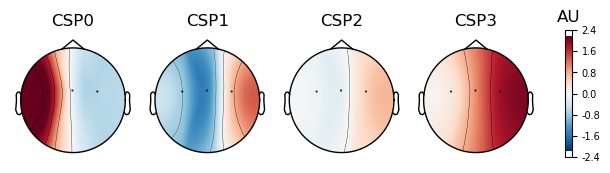

Train Accuracy: 0.6666666666666666
Test  Accuracy: 0.5333333333333333
              precision    recall  f1-score   support

  none-right       0.53      0.60      0.56        15
       right       0.54      0.47      0.50        15

    accuracy                           0.53        30
   macro avg       0.53      0.53      0.53        30
weighted avg       0.53      0.53      0.53        30

Using features which yield maximum accuracy----------------------
Train set shape: (120, 4)
Test set shape : (30, 4)


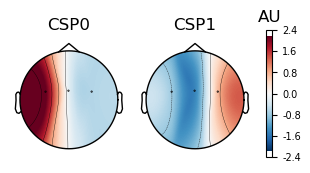

Train Accuracy: 0.6333333333333333
Test  Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

  none-right       0.67      0.67      0.67        15
       right       0.67      0.67      0.67        15

    accuracy                           0.67        30
   macro avg       0.67      0.67      0.67        30
weighted avg       0.67      0.67      0.67        30



In [ ]:
csp_list = []
lr_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, lr.predict(X_train)))

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

### 2.4 Left vs. Non-left Classification

#### 2.4.1 SVM

Using all features ----------------------------------------------
Train set shape: (184, 4)
Test set shape : (46, 4)


c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\li

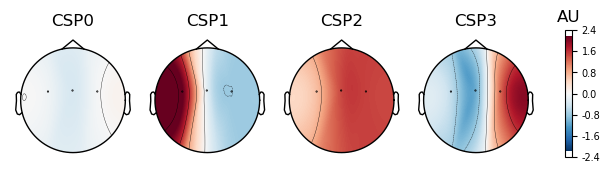

Train Accuracy: 0.6739130434782609
Test  Accuracy: 0.6739130434782609
              precision    recall  f1-score   support

       right       0.67      1.00      0.81        31
        left       0.00      0.00      0.00        15

    accuracy                           0.67        46
   macro avg       0.34      0.50      0.40        46
weighted avg       0.45      0.67      0.54        46

Using features which yield maximum accuracy----------------------
Train set shape: (184, 4)
Test set shape : (46, 4)


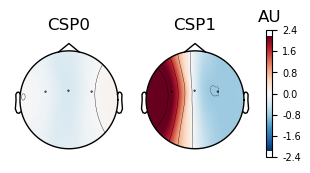

Train Accuracy: 0.6739130434782609
Test  Accuracy: 0.6739130434782609
              precision    recall  f1-score   support

       right       0.67      1.00      0.81        31
        left       0.00      0.00      0.00        15

    accuracy                           0.67        46
   macro avg       0.34      0.50      0.40        46
weighted avg       0.45      0.67      0.54        46



In [ ]:
epochs_clean_plain_l = epochs_clean_plain.copy()
epochs_clean_plain_l.events = mne.merge_events(epochs_clean_plain_l.events, [0, 1], 0, replace_events=True)
epochs_clean_plain_l.event_id = {'none-left': 0, 'left': 2}

# Get EEG data and events
X = epochs_clean_plain_l.get_data(copy=False)
Y = epochs_clean_plain_l.events[:, -1]

csp_list = []
svm_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, svm.predict(X_train)))

    report = classification_report(Y_test, y_pred, target_names=['right', 'left'])  # adjust target names accordingly
    report_list.append(report)

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 2.4.2 Logistic Regression

Using all features ----------------------------------------------
Train set shape: (184, 4)
Test set shape : (46, 4)


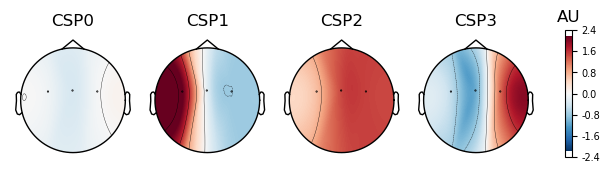

Train Accuracy: 0.6684782608695652
Test  Accuracy: 0.6739130434782609
              precision    recall  f1-score   support

  none-right       0.70      0.90      0.79        31
       right       0.50      0.20      0.29        15

    accuracy                           0.67        46
   macro avg       0.60      0.55      0.54        46
weighted avg       0.63      0.67      0.62        46

Using features which yield maximum accuracy----------------------
Train set shape: (184, 4)
Test set shape : (46, 4)


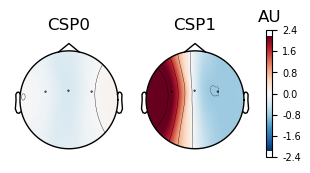

Train Accuracy: 0.6902173913043478
Test  Accuracy: 0.6739130434782609
              precision    recall  f1-score   support

  none-right       0.69      0.94      0.79        31
       right       0.50      0.13      0.21        15

    accuracy                           0.67        46
   macro avg       0.60      0.53      0.50        46
weighted avg       0.63      0.67      0.60        46



In [ ]:
csp_list = []
lr_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, lr.predict(X_train)))

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

### 2.5 Right vs. Non-Right Classification

#### 2.5.1 SVM

Using all features ----------------------------------------------
Train set shape: (184, 4)
Test set shape : (46, 4)


c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\li

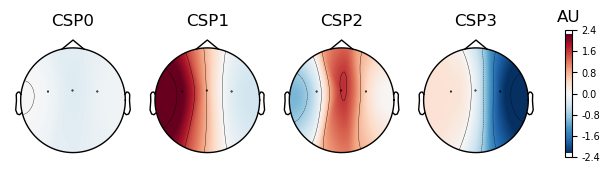

Train Accuracy: 0.6739130434782609
Test  Accuracy: 0.6739130434782609
              precision    recall  f1-score   support

       right       0.67      1.00      0.81        31
        left       0.00      0.00      0.00        15

    accuracy                           0.67        46
   macro avg       0.34      0.50      0.40        46
weighted avg       0.45      0.67      0.54        46

Using features which yield maximum accuracy----------------------
Train set shape: (184, 4)
Test set shape : (46, 4)


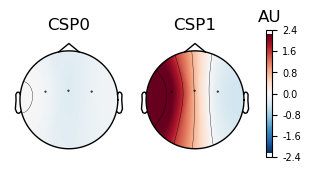

Train Accuracy: 0.6739130434782609
Test  Accuracy: 0.6739130434782609
              precision    recall  f1-score   support

       right       0.67      1.00      0.81        31
        left       0.00      0.00      0.00        15

    accuracy                           0.67        46
   macro avg       0.34      0.50      0.40        46
weighted avg       0.45      0.67      0.54        46



In [ ]:
epochs_clean_plain_r = epochs_clean_plain.copy()
epochs_clean_plain_r.events = mne.merge_events(epochs_clean_plain_r.events, [0, 2], 0, replace_events=True)
epochs_clean_plain_r.event_id = {'none-right': 0, 'right': 1}

# Get EEG data and events
X = epochs_clean_plain_r.get_data(copy=False)
Y = epochs_clean_plain_r.events[:, -1]

csp_list = []
svm_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, svm.predict(X_train)))

    report = classification_report(Y_test, y_pred, target_names=['right', 'left'])  # adjust target names accordingly
    report_list.append(report)

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 2.5.2 Logistic Regression

Using all features ----------------------------------------------
Train set shape: (184, 4)
Test set shape : (46, 4)


c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


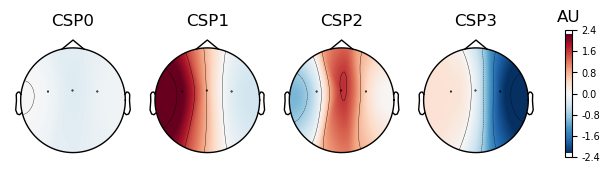

Train Accuracy: 0.6956521739130435
Test  Accuracy: 0.6086956521739131
              precision    recall  f1-score   support

  none-right       0.65      0.90      0.76        31
       right       0.00      0.00      0.00        15

    accuracy                           0.61        46
   macro avg       0.33      0.45      0.38        46
weighted avg       0.44      0.61      0.51        46

Using features which yield maximum accuracy----------------------
Train set shape: (184, 4)
Test set shape : (46, 4)


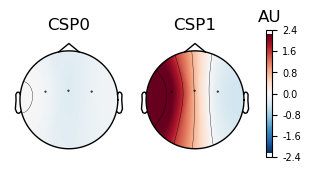

Train Accuracy: 0.6739130434782609
Test  Accuracy: 0.6739130434782609
              precision    recall  f1-score   support

  none-right       0.67      1.00      0.81        31
       right       0.00      0.00      0.00        15

    accuracy                           0.67        46
   macro avg       0.34      0.50      0.40        46
weighted avg       0.45      0.67      0.54        46



In [ ]:
csp_list = []
lr_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, lr.predict(X_train)))

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])